# `fmri-11`: Forward encoding models
This demo introduces forward encoding models—that is, using regularized regression to predict voxelwise activity from an explicit model of the stimulus in left-out data. Here, we use a semantic forward encoding model capturing the meaning of words to predict fMRI activity while participants listen to a spoken narrative (similarly to e.g. [Huth et al., 2016](https://doi.org/10.1038/nature17637)). The words in each TR are assigned a vector representing their location in a high-dimensional semantic space. For each voxel, we'll fit a model that predicts the time series of brain activity from the semantic vectors assigned to eachtime point.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import pandas as pd
import json

### Naturalistic story-listening dataset
As an example, we'll use fMRI data collected for a single subject listening to a spoken story called "[I Knew You Were Black](https://themoth.org/stories/i-knew-you-were-black)" by Carol Daniel. These data are available as part of the publicly available [Narratives](https://github.com/snastase/narratives) collection ([Nastase et al., 2019](https://openneuro.org/datasets/ds002345)). Here, we download a pre-packaged subset of the data from Zenodo. These data have been preprocessed using fMRIPrep with confound regression in AFNI. To reduce computational demands, we compute parcel-wise ISCs using a cortical parcellation containing 400 parcels from Schaefer and colleages (2018).

In [2]:
# Filenames for intact notthefall data and Schaefer atlas
func_fn = ('brainiak-aperture-srm-data/sub-284_task-black_'
           'space-MNI152NLin2009cAsym_res-native_desc-clean_bold.nii.gz')
atlas_fn = 'brainiak-aperture-srm-data/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2.5mm.nii.gz'

# Load in the Schaefer 400-parcel atlas
atlas_nii = nib.load(atlas_fn)
atlas_img = atlas_nii.get_fdata()

# Load in intact functional data and compute parcel means
func_data = nib.load(func_fn).get_fdata()
func_means = [np.mean(func_data[atlas_img == parcel, :], axis=0)
                for parcel in np.unique(atlas_img)[1:]]
func_parcels = np.column_stack(func_means)

In [3]:
func_parcels.shape

(550, 400)

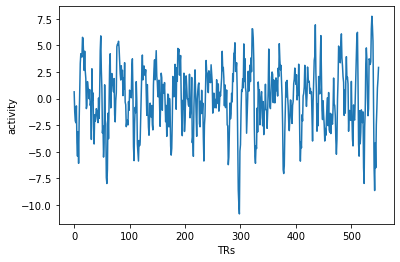

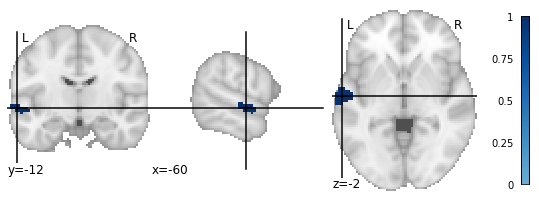

In [4]:
# Plot the time series for an example parcel in left auditory association cortex
from nilearn.plotting import plot_stat_map

example_parcel = 196

func_parcel = func_parcels[:, example_parcel]
plt.plot(func_parcel)
plt.xlabel('TRs')
plt.ylabel('activity')
plt.show()

roi_img = np.zeros(atlas_img.shape)
roi_img[atlas_img == example_parcel] = 1
roi_nii = nib.Nifti1Image(roi_img, atlas_nii.affine, atlas_nii.header)
plot_stat_map(roi_nii, cmap='Blues');

### Semantic encoding model
We'll decompose the story stimulus into a series of semantic features based on a simply, widely used representation of word meaning called GloVe ([Pennington et al., 2014](http://dx.doi.org/10.3115/v1/D14-1162])). GloVe represents each word in a 300-dimensional semantic space where words that are nearer in space are more semantically similar based on co-occurrence statistics from a large corpus of text. We start with a time-stamped stimulus transcript. For each TR, we identify which words occurred in that TR, then assign that TR the semantic embeddings associated with each word. For TRs with multiple words, we average the semantic embeddings; for TRs with no words, we use a 300-dimensional vector of zeros; we exclude a small number of stop words. Finally, to account for the hemodynamic lag in fMRI, we create lagged versions of the embeddings.

In [5]:
# Load in time-stamped transcript
transcript_fn = 'black_gentle.csv'
transcript = pd.read_csv(transcript_fn, sep=',')

# Stimulus is roughly 800 seconds long
tr = 1.5
stim_dur = 800
stim_trs = 800 // tr

# Convert transcript to list for simplicity
transcript = transcript.values.tolist()

# Loop through TRs
transcript_trs = []
for t in np.arange(stim_trs):
    
    # Container for words in this TR
    tr_words = []
    
    # Check if upcoming word onset is in this TR
    while t * tr < transcript[0][2] <= t * tr + tr:
        
        # If so, pop this word out of list and keep it
        w = transcript.pop(0)
        tr_words.append(w[0])
        
    # Append words and move to the next TR
    transcript_trs.append(tr_words)

In [6]:
# Load in dictionary of GloVe embeddings
with open('glove_embeddings.json') as f:
    glove = json.load(f)
    
# Load list of standard stop words
stopwords = np.load('nltk_stopwords.npy')

In [7]:
# Assign GloVe embeddings to each TR
glove_dim = 300

embeddings = []
for t in transcript_trs:
    embeddings_tr = []
    
    # Grab the embedding for each word in a TR
    for w in t:
        
        # Ignore stop words
        if w not in stopwords:
            embeddings_tr.append(glove[w])
        
    # For non-empty TRs, average the embeddings
    if len(embeddings_tr) > 0:
        embeddings_tr = np.mean(embeddings_tr, axis=0)
    else:
        embeddings_tr = np.zeros(glove_dim)
    embeddings.append(embeddings_tr)

embeddings = np.stack(embeddings, axis=0)

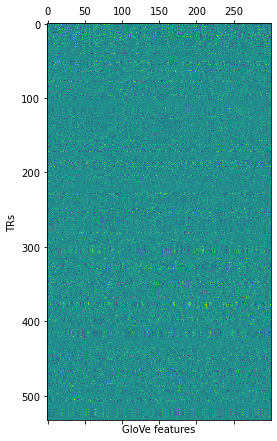

In [8]:
# Visualize GloVe embeddings
from scipy.stats import zscore
plt.matshow(zscore(embeddings, axis=0))
plt.xlabel('GloVe features')
plt.ylabel('TRs');

In [9]:
# Create temporally delayed version of embeddings
lags = [2, 3, 4, 5]

embeddings_lag = []
for lag in lags:
    prepend = np.zeros((lag, glove_dim))
    append = np.zeros((lags[-1] - lag, glove_dim))
    lagged = np.vstack((prepend, embeddings, append))
    embeddings_lag.append(lagged)

# Horizontally stack lagged embeddings
embeddings_lag = np.hstack(embeddings_lag)

# Z-score embeddings as well
from scipy.stats import zscore
embeddings_lag = zscore(embeddings_lag, axis=0)

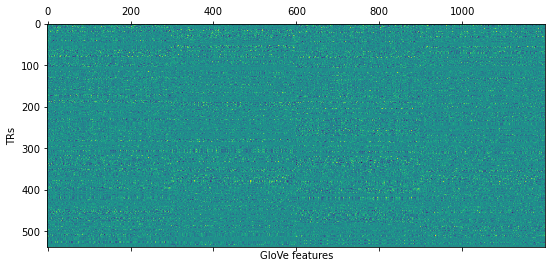

In [10]:
plt.matshow(embeddings_lag)
plt.xlabel('GloVe features')
plt.ylabel('TRs');

In [11]:
# Trim fMRI data to match embeddings
start_trs = 8
end_trs = 9 - lags[-1]

assert start_trs + embeddings_lag.shape[0] + end_trs == func_parcels.shape[0]

func_parcels = func_parcels[start_trs:-end_trs]

### Ridge regression
Next, we use ridge regression to predict the activity at each parcel from the semantic embeddings. Note that the model dimensionality ($300 * 4$ delays $= 1200$ dimensions) is much greater than the number of samples ($<550$ TRs). This means we'll need to impose strong regularization on the model. We use a split-half outer cross-validation scheme where we train the model on half of the story and test the model on the other half. To search for the best-performing regularization parameter, we perform 5-fold inner cross-validation within each training set; we use the best parameter setting from the inner cross-validation fold within the training half to predict the test half.

In [12]:
# Split-half outer cross-validation fold
from sklearn.model_selection import KFold

cv = KFold(n_splits=2)

# Ridge regression with alpha grid and nested CV
from sklearn.linear_model import RidgeCV

alphas = [0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
nested_cv = KFold(n_splits=5)
ridge = RidgeCV(alphas=alphas, cv=nested_cv, scoring='r2')

# Loop through outer split-half cross-validation
func_predicted = []
for train, test in cv.split(func_parcels):
    
    # Fit ridge regression with grid search
    ridge.fit(embeddings_lag[train],
              func_parcels[train])
    
    # Compute predicted response
    predicted = ridge.predict(embeddings_lag[test])
    func_predicted.append(predicted)
    
# Restack first and second half predictions
func_predicted = np.vstack(func_predicted)

### Evaluating model performance
To evaluate the predictions of our model, we use a model fit to the training data to predict the brain activity from semantic embeddings for the test data. We then assess the similarity between the predicted brain activity and the actual brain activity for the test data. Keeping with conventions in the literature, we use Pearson correlation to assess the match between predicted and actual brain activity (although this is not considered a good scoring metric in machine learning and there are many other options; e.g. $R^2$).

In [13]:
# Compute correlation between predicted and actual responses
from scipy.stats import pearsonr

r_parcels = []
for parcel in np.arange(func_parcels.shape[1]):
    r_parcels.append(pearsonr(func_parcels[:, parcel],
                              func_predicted[:, parcel])[0])

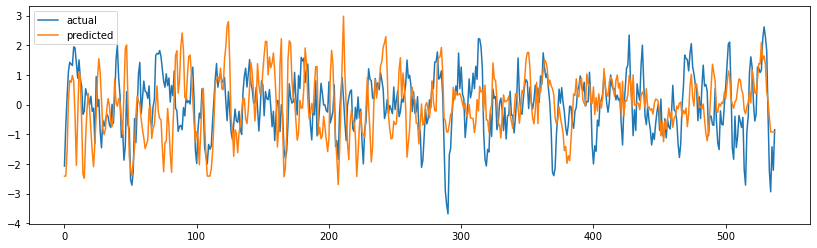

In [14]:
# Plot predicted and actual response for example parcel
example_parcel = 196
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(zscore(func_parcels[:, example_parcel]), label='actual')
ax.plot(zscore(func_predicted[:, example_parcel]), label='predicted')
ax.legend();

In [15]:
r_parcels[example_parcel]

0.30543726006667593

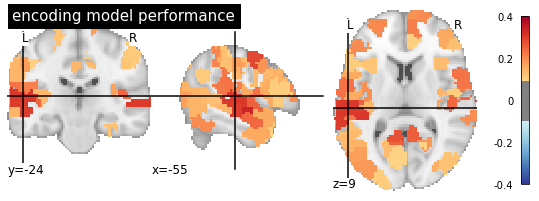

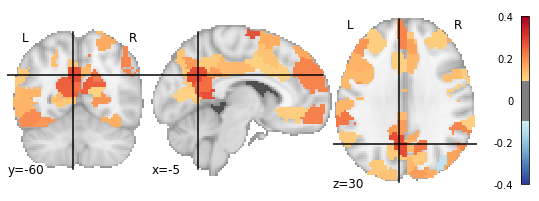

In [16]:
# Plot correlations between actual and predicted responses
from nilearn.plotting import plot_stat_map

r_img = np.zeros(atlas_img.shape)
for i, parcel in enumerate(np.unique(atlas_img)[1:]):
    r_img[atlas_img == parcel] = r_parcels[i]

# Convert to NIfTI image for visualization with Nilearn
r_nii = nib.Nifti1Image(r_img, atlas_nii.affine, atlas_nii.header)

# Plot correlations to visualize superior temporal cortex
vmax = .4
threshold = .1
plot_stat_map(r_nii, cmap='RdYlBu_r', vmax=vmax, threshold=threshold,
              title='encoding model performance', cut_coords=(-55, -24, 9))

# Plot correlations to visualize posterior medial cortex
plot_stat_map(r_nii, cmap='RdYlBu_r', vmax=vmax, threshold=threshold,
              cut_coords=(-5, -60, 30));

#### References

* Huth, A. G., De Heer, W. A., Griffiths, T. L., Theunissen, F. E., & Gallant, J. L. (2016). Natural speech reveals the semantic maps that tile human cerebral cortex. *Nature*, *532*(7600), 453-458. https://doi.org/10.1038/nature17637

* Nastase, S. A., Liu, Y.-F., Hillman, H., Zadbood, A., Hasenfratz, L., Keshavarzian, N., Chen, J., Honey, C. J., Yeshurun, Y., Regev, M., Nguyen, M., Chang, C. H. C., Baldassano, C., Lositsky, O., Simony, E., Chow, M. A., Leong, Y. C., Brooks, P. P., Micciche, E., Choe, G., Goldstein, A., Vanderwal, T., Halchenko, Y. O., Norman, K. A., & Hasson, U. (2020). Narratives: fMRI data for evaluating models of naturalistic language comprehension. *bioRxiv*. https://doi.org/10.1101/2020.12.23.424091

* Pennington, J., Socher, R., & Manning, C. D. (2014, October). GloVe: Global Vectors for Word Representation. In *Proceedings of the 2014 Conference on Empirical Methods in Natural Language Processing (EMNLP)* (pp. 1532-1543). https://www.aclweb.org/anthology/D14-1162

* Schaefer, A., Kong, R., Gordon, E. M., Laumann, T. O., Zuo, X. N., Holmes, A. J., ... & Yeo, B. T. (2018). Local-global parcellation of the human cerebral cortex from intrinsic functional connectivity MRI. Cerebral cortex, 28(9), 3095-3114. https://doi.org/10.1093/cercor/bhx179